# Support Vector Machines (SVM)

### Exercise 1: Visualizing SVM Decision Boundaries

In this exercise, you will generate a simple 2D dataset that may be linearly separable or non-linearly separable. You will then train SVM models using both a linear kernel and an RBF (Gaussian) kernel.

You will visualize:
- the decision boundary (where the classifier outputs 0),
- the margin boundaries (decision score +1 and −1),
- and the support vectors used by the classifier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

In [3]:
svm_linear = svm.SVC(kernel='linear', C=1000)
svm_rbf = svm.SVC(kernel='rbf', C=1000, gamma='auto')

svm_linear.fit(X, y)
svm_rbf.fit(X, y)

SVC(C=1000, gamma='auto')

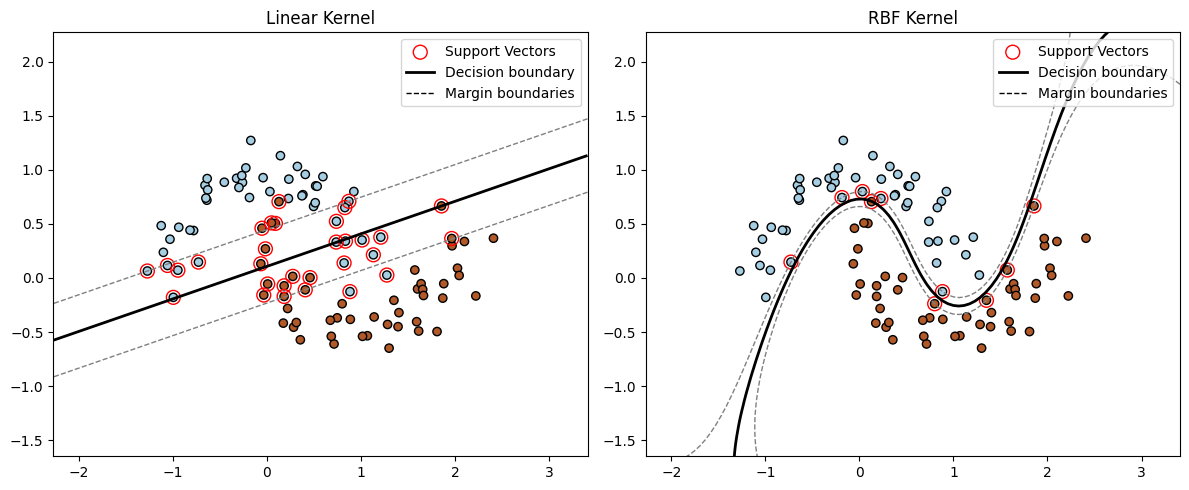

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

DecisionBoundaryDisplay.from_estimator(
    svm_linear, X, plot_method="contour",
    ax=ax1, levels=[0], colors='black', linewidths=2
)

DecisionBoundaryDisplay.from_estimator(
    svm_linear, X, plot_method="contour",
    ax=ax1, levels=[-1, 1], colors='gray', linewidths=1, linestyles='--'
)

ax1.scatter(svm_linear.support_vectors_[:, 0],
            svm_linear.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='red',
            label='Support Vectors')

ax1.set_title('Linear Kernel')

ax1.plot([], [], 'k-', linewidth=2, label='Decision boundary')
ax1.plot([], [], 'k--', linewidth=1, label='Margin boundaries')

ax1.legend()

ax2.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

DecisionBoundaryDisplay.from_estimator(
    svm_rbf, X, plot_method="contour",
    ax=ax2, levels=[0], colors='black', linewidths=2
)

DecisionBoundaryDisplay.from_estimator(
    svm_rbf, X, plot_method="contour",
    ax=ax2, levels=[-1, 1], colors='gray', linewidths=1, linestyles='--'
)

ax2.scatter(svm_rbf.support_vectors_[:, 0],
            svm_rbf.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='red',
            label='Support Vectors')

ax2.set_title('RBF Kernel')

ax2.plot([], [], 'k-', linewidth=2, label='Decision boundary')
ax2.plot([], [], 'k--', linewidth=1, label='Margin boundaries')

ax2.legend()

plt.tight_layout()
plt.show()

### Exercise 2: Logistic Regression vs. Linear SVM


Train two classifiers on the same 2D dataset:
- Linear SVM (using a linear kernel)
- Logistic Regression

Plot both decision boundaries on the same figure and visually compare them.

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
log_clf = LogisticRegression()
log_clf.fit(X, y)

LogisticRegression()

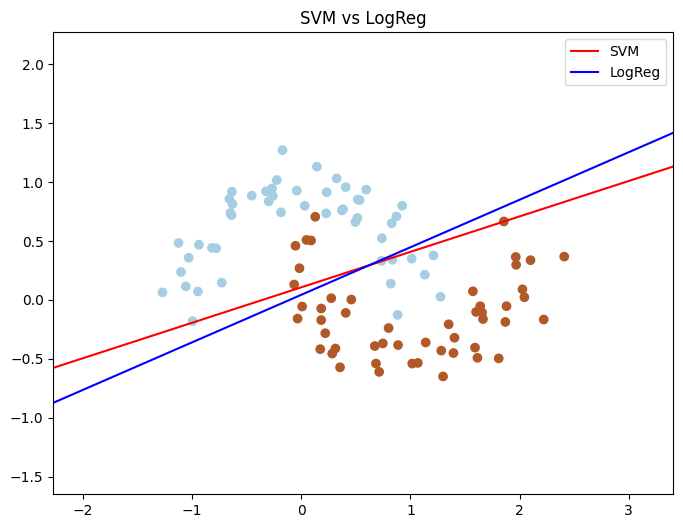

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

DecisionBoundaryDisplay.from_estimator(
    svm_linear, X, plot_method="contour", colors="r", ax=ax, levels=[0]
)

DecisionBoundaryDisplay.from_estimator(
    log_clf, X, plot_method="contour", colors="b", ax=ax, levels=[0]
)

ax.plot([], [], 'r-', label='SVM')
ax.plot([], [], 'b-', label='LogReg')
ax.legend(loc='upper right')

plt.title('SVM vs LogReg')
plt.show()

### Exercise 3: Predicting Phishing Websites Using SVM


In this exercise, you will train an SVM model to distinguish legitimate websites from phishing websites based on features such as URL length, presence of suspicious characters, domain age, HTTPS usage, and more.

You will:
- Train an SVM classifier
- After training, compute and report:
    - Accuracy
	- F1 Score
	- Confusion Matrix
- Discuss what each metric tells you about model performance and class imbalance.
- Analyze incorrect predictions
    - Inspect the samples the model classified incorrectly.
    - For each type of misclassified case, try to answer:
	    - What feature patterns might have confused the model?
	    - Could noise or missing information be causing errors?
	    - Do certain phishing attempts closely resemble legitimate behavior?



In [8]:
!pip install -U ucimlrepo
from ucimlrepo import fetch_ucirepo
# https://archive.ics.uci.edu/dataset/327/phishing+websites
dataset = fetch_ucirepo(id=327)
X = dataset.data.features
y = dataset.data.targets

In [9]:
y["result"].unique()

array([-1,  1])

In [10]:
X.isna().sum().sum()

np.int64(0)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=42)

In [18]:
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
cm = confusion_matrix(y_test, y_pred)

print(f"ACC: {acc},\nF1: {f1},\nConfusion matrix:\n{cm}")

ACC: 0.9240277359059391,
F1: 0.9337539432176656,
Confusion matrix:
[[1289  139]
 [ 113 1776]]


### Misclassified sample analysis

In [19]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(clf.coef_[0])
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(5)['feature'].tolist()
print(f"Top 5 most important features: {top_features}")

print("_"*50,"\n")

fp_samples = X_test.iloc[(y_test == -1) & (y_pred == 1)]
correct_phishing = X_test.iloc[(y_test == -1) & (y_pred == -1)]

print(f"FP features that differ from TN significantly:")
for feature in top_features:
    fp_mean = fp_samples[feature].mean()
    correct_mean = correct_phishing[feature].mean()
    diff = fp_mean - correct_mean

    if abs(diff) > 0.3:
        direction = "Higher" if diff > 0 else "Lower"
        print(f"{feature}: FP = {fp_mean:.2f}, TN = {correct_mean:.2f}, Diff = {diff:.2f}. {direction} than TN")

print("_"*50,"\n")

fn_samples = X_test.iloc[(y_test == 1) & (y_pred == -1)]
correct_legitimate = X_test.iloc[(y_test == 1) & (y_pred == 1)]

print(f"FN features that differ from TP significantly:")
for feature in top_features:
    fn_mean = fn_samples[feature].mean()
    correct_mean = correct_legitimate[feature].mean()
    diff = fn_mean - correct_mean

    if abs(diff) > 0.3:
        direction = "Higher" if diff > 0 else "Lower"
        print(f"{feature}: FN = {fn_mean:.2f}, TP = {correct_mean:.2f}, Diff = {diff:.2f}. {direction} than TP")

Top 5 most important features: ['url_of_anchor', 'prefix_suffix', 'sslfinal_state', 'redirect', 'links_pointing_to_page']
__________________________________________________ 

FP features that differ from TN significantly:
url_of_anchor: FP = 0.12, TN = -0.72, Diff = 0.85. Higher than TN
sslfinal_state: FP = 0.76, TN = -0.60, Diff = 1.36. Higher than TN
__________________________________________________ 

FN features that differ from TP significantly:
url_of_anchor: FN = -0.05, TP = 0.40, Diff = -0.45. Lower than TP
prefix_suffix: FN = -1.00, TP = -0.51, Diff = -0.49. Lower than TP
sslfinal_state: FN = -0.51, TP = 0.92, Diff = -1.43. Lower than TP
